# Music Therapy Investigation

The purpose of this analysis is to discover trends in music therapy which might help improve the practice. Particularly of interest is the preferred genre of music of patients, and how it relates to the success of the treatment. If a clear trend could be established, this could help enhance music therapy practice for others in the future. A few other relationships can be explored as well, such as the effect of the average BPM of their favorite genre on the success of their treatment, and the frequency with which they listen to various genres.

## Null and Alternative Hypotheses

**Null Hypothesis**: The success of music therapy treatment does not depend on the musical selection or any other musical factors.

**Alternative Hypothesis**: Choice of musical genre does have an impact on the success of music therapy treatment.

In [88]:
# Import necessary libraries

import re
import pandas as pd
import numpy as np

# Visualization libraries

import matplotlib.pyplot as plt
import seaborn as sns

# Statistics libraries

import statsmodels as sm
from scipy.stats import f_oneway, chi2_contingency, kendalltau, levene

# Machine Learning libraries

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
import warnings
from sklearn.exceptions import FitFailedWarning

warnings.filterwarnings('ignore', category=FitFailedWarning)
warnings.filterwarnings('once', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
# Set a random_state number to be used throughout the analysis

random_state = 42

In [4]:
# Import cleaned data

survey_df = pd.read_csv('../data/interim/clean_survey_results.csv')
survey_df.head()

,Age,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,BPM,Frequency [Classical],...,Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects
0,18,4.0,No,No,No,Video game music,No,Yes,132.0,Never,...,Rarely,Never,Rarely,Rarely,Very frequently,7,7,10,2,No effect
1,61,2.5,Yes,No,Yes,Jazz,Yes,Yes,84.0,Sometimes,...,Sometimes,Sometimes,Never,Never,Never,9,7,3,3,Improve
2,18,4.0,Yes,No,No,R&B,Yes,No,107.0,Never,...,Sometimes,Very frequently,Very frequently,Never,Rarely,7,2,5,9,Improve
3,18,5.0,Yes,Yes,Yes,Jazz,Yes,Yes,86.0,Rarely,...,Very frequently,Very frequently,Very frequently,Very frequently,Never,8,8,7,7,Improve
4,18,3.0,Yes,Yes,No,Video game music,Yes,Yes,66.0,Sometimes,...,Rarely,Rarely,Never,Never,Sometimes,4,8,6,0,Improve


# Exploring BPM

Being one of the few continuous variables in this dataset, understanding this column could help develop effective predictive models. Its relationship with genre is particularly of interest. If there is a relationship between BPM and genre, then it can be effective in predicting Music effects.

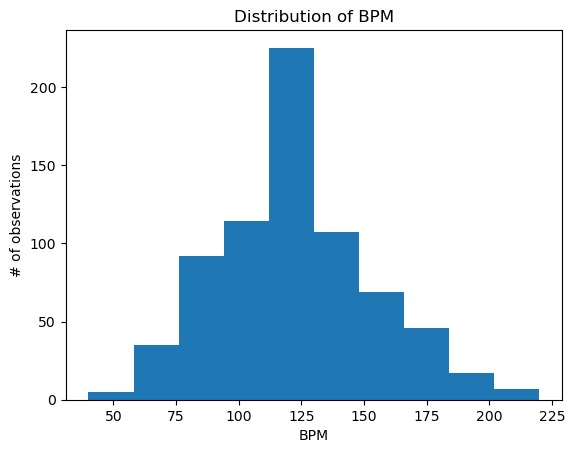

In [5]:
# Visualize overall distribution of BPM

plt.hist(survey_df['BPM'])
plt.xlabel('BPM')
plt.ylabel('# of observations')
plt.title('Distribution of BPM')

plt.show()

BPM appears to be normally distributed across the dataset. Let's see how it's distributed grouped by genre.

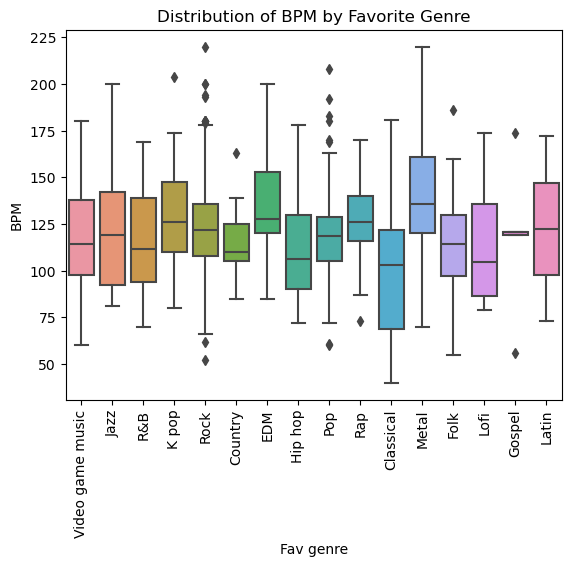

In [6]:
# Visualize distribution of BPM by genre

sns.boxplot(x='Fav genre', y='BPM', data=survey_df)

plt.xticks(rotation=90)
plt.title('Distribution of BPM by Favorite Genre')

plt.show()

This figure reveals that the median BPM of each genre does lie somewhere between 100 and 130. Some genres, such as Classical, have a much wider IQR, implying that data is less clustered around the median and more dispersed. Some genres have highly right-skewed BPM, such as Lofi and Jazz. 

The figure also reveals that very few respondents selected Gospel as their favorite genre, and that Pop and Rock have the most outlying BPM.

We'll use an ANOVA test to test whether statistically significant differences exist in BPM between genres.

### ANOVA Test

**Null hypothesis**: There is no significant difference in mean BPM per genre.

**Alternative hypothesis**: At least one genre has a significantly different mean BPM from the other groups.

In [7]:
# Separate data by genre
genres = survey_df['Fav genre'].unique()
bpm_groups = [survey_df[survey_df['Fav genre'] == genre]['BPM'] for genre in genres]

# Perform one-way ANOVA
f_stat, p_value = f_oneway(*bpm_groups)

print(f"F-statistic: {f_stat}, p-value: {p_value}")

F-statistic: 4.903205085799289, p-value: 3.5179055372079076e-09


The p-value represents the probability that a large difference in mean BPM was observed purely by chance between genres. Since this is very low, this means we can reject the null hypothesis and conclude that there is a statistically significant difference between mean BPM.

The f-statistic is relatively large, implying that there is more variation between genre mean BPMs rather than within each genre.

# Music Effects for Musicians

Musicians have an entirely different way of absorbing and experiencing music. This is in part due to their training, which exposes them to different methods of listening to music and especially analyzing it. It is worth exploring, in that case, if the outcomes of music therapy are different for these groups. For the purposes of this test, `Instrumentalist` and `Composer` columns will be combined into a `Musician` column. This column will contain a 1 if they are an Instrumentalist, meaning they play an instrument, or a Composer, meaning they compose music, and a 0 otherwise. Then we will perform a chi-squared test with a significance level of 0.05 to compare this column with `Music effects` in order to see if these columns are independent of one another or not.

**Null Hypothesis**: Being a musician does not have any relationship to the outcome of music therapy treatment.

**Alternative Hypothesis**: Being a musician will have a significant impact on the success ofmusic therapy treatment.

In [8]:
# Create Musician column

survey_df['Musician'] = ((survey_df['Instrumentalist'] == 'Yes') | (survey_df['Composer'] == 'Yes')).astype('str')
survey_df.head()

,Age,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,BPM,Frequency [Classical],...,Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects,Musician
0,18,4.0,No,No,No,Video game music,No,Yes,132.0,Never,...,Never,Rarely,Rarely,Very frequently,7,7,10,2,No effect,False
1,61,2.5,Yes,No,Yes,Jazz,Yes,Yes,84.0,Sometimes,...,Sometimes,Never,Never,Never,9,7,3,3,Improve,True
2,18,4.0,Yes,No,No,R&B,Yes,No,107.0,Never,...,Very frequently,Very frequently,Never,Rarely,7,2,5,9,Improve,False
3,18,5.0,Yes,Yes,Yes,Jazz,Yes,Yes,86.0,Rarely,...,Very frequently,Very frequently,Very frequently,Never,8,8,7,7,Improve,True
4,18,3.0,Yes,Yes,No,Video game music,Yes,Yes,66.0,Sometimes,...,Rarely,Never,Never,Sometimes,4,8,6,0,Improve,True


In [9]:
# Calculate proportion of musicians to nonmusicians by music effects in order to plot

counts = survey_df.groupby(['Music effects', 'Musician']).size().reset_index(name='Count')
totals = survey_df.groupby('Music effects')['Musician'].count().reset_index(name='Total')
merged_df = pd.merge(counts, totals)
merged_df['Proportion'] = (merged_df['Count'] / merged_df['Total'])

merged_df

,Music effects,Musician,Count,Total,Proportion
0,Improve,False,317,534,0.593633
1,Improve,True,217,534,0.406367
2,No effect,False,124,166,0.746988
3,No effect,True,42,166,0.253012
4,Worsen,False,13,17,0.764706
5,Worsen,True,4,17,0.235294


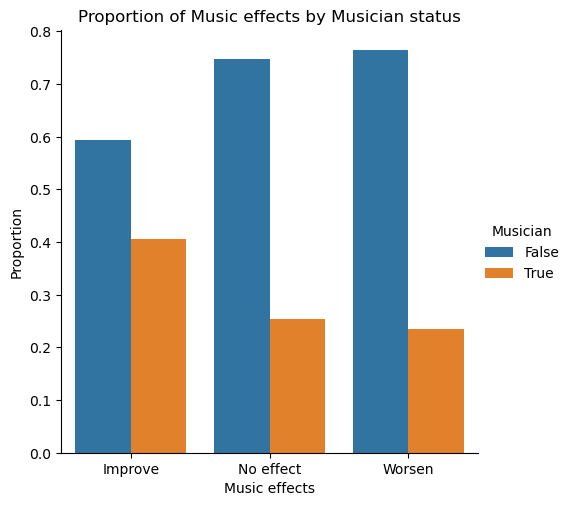

In [10]:
# Plot data

sns.catplot(data=merged_df, x='Music effects', y='Proportion', hue='Musician', kind='bar')

plt.title('Proportion of Music effects by Musician status')

plt.show()

This plot reveals that being a musician does not result in a higher proportion of improvement than for nonmusicians. It does, however, show nonmusicians are significantly more likely to worsen after music therapy treatment than musicians.

In [11]:
# Create contingency table

contingency_table = pd.crosstab(survey_df['Music effects'], survey_df['Musician'])
print(contingency_table)

Musician       False  True
Music effects             
Improve          317   217
No effect        124    42
Worsen            13     4


In [12]:
# Run chi-squared test using sample contingency table

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-squared test statistic: {chi2}, P-value: {p}")

Chi-squared test statistic: 14.119198454591137, P-value: 0.0008591223377707166


This contingency table reveals that there are only 4 cases where a musician's treatment worsened. According to the documentation of the scipy chi-squared test, this test is only valid if the observed frequencies in each cell are at least 5. To mitigate this, we will apply bootstrapping to the data to increase our sample size, and then re-evaluate the data to perform this test.

In [13]:
# Bootstrap data with n=2,000

bootstrapped_survey = pd.concat([survey_df, survey_df.sample(n=2000, replace=True, random_state=random_state)])
bootstrapped_survey.shape

(2717, 31)

In [14]:
# Calculate proportions in bootstrapped data

counts = bootstrapped_survey.groupby(['Music effects', 'Musician']).size().reset_index(name='Count')
totals = bootstrapped_survey.groupby('Music effects')['Musician'].count().reset_index(name='Total')
merged_df = pd.merge(counts, totals)
merged_df['Proportion'] = (merged_df['Count'] / merged_df['Total'])

merged_df

,Music effects,Musician,Count,Total,Proportion
0,Improve,False,1192,2011,0.592740
1,Improve,True,819,2011,0.407260
2,No effect,False,481,646,0.744582
3,No effect,True,165,646,0.255418
4,Worsen,False,43,60,0.716667
5,Worsen,True,17,60,0.283333


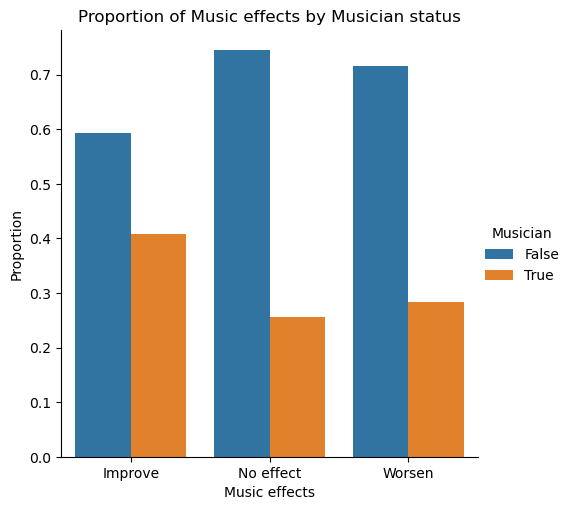

In [15]:
# Plot data

sns.catplot(data=merged_df, x='Music effects', y='Proportion', hue='Musician', kind='bar')

plt.title('Proportion of Music effects by Musician status')

plt.show()

This plot reveals the same information as the original survey data.

In [16]:
# Re-create contingency table with bootstrapped sample

contingency_table = pd.crosstab(bootstrapped_survey['Music effects'], bootstrapped_survey['Musician'])
contingency_table

Musician,False,True
Music effects,,
Improve,1192,819
No effect,481,165
Worsen,43,17


In [17]:
# Run chi-squared test using bootstrapped contingency table

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-squared test statistic: {chi2}, P-value: {p}")

Chi-squared test statistic: 50.35585925983189, P-value: 1.1624227364695092e-11


The calculated p-value is significantly lower than when we ran the test with the sample data, and the test statistic is much higher. Both tests allow us to reject the null hypothesis that there is no relationship between being a musician and success of music therapy treatment.

# Effectiveness of Treatment for Patients with Anxiety, Depression, Insomnia, and OCD

It is of particular interest if a significant proportion of individuals suffering with these conditions saw improvement through music therapy. If so, music therapy can be proven to be a viable treatment option for these conditions which often are treated through medications or more aggressive treatments.

We are only interested in whether or not these individuals saw improvement following treatment. Therefore, we will add a new column called `Improve`, which will contain `True` for when a patient saw improvement, and `False` otherwise. We will also equally divide the `Anxiety`, `Depression`, `Insomnia`, and `OCD` columns into three bins labelled Mild, Moderate, and Severe. A chi-squared test with a significance level of 0.05 will be implemented in order to examine the relationship between these columns.

**Null Hypothesis**: The effects of music therapy were the same for all patients, regardless of Anxiety, Depression, Insomnia, or OCD levels.

**Alternative Hypothesis**: The effects of music therapy vary depending on the patients Anxiety, Depression, Insomnia, or OCD levels.

In [18]:
# Create Improve column which represents whether the patient improved or not

survey_df['Improve'] = (survey_df['Music effects'] == 'Improve').astype(str)
survey_df.head()

,Age,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,BPM,Frequency [Classical],...,Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects,Musician,Improve
0,18,4.0,No,No,No,Video game music,No,Yes,132.0,Never,...,Rarely,Rarely,Very frequently,7,7,10,2,No effect,False,False
1,61,2.5,Yes,No,Yes,Jazz,Yes,Yes,84.0,Sometimes,...,Never,Never,Never,9,7,3,3,Improve,True,True
2,18,4.0,Yes,No,No,R&B,Yes,No,107.0,Never,...,Very frequently,Never,Rarely,7,2,5,9,Improve,False,True
3,18,5.0,Yes,Yes,Yes,Jazz,Yes,Yes,86.0,Rarely,...,Very frequently,Very frequently,Never,8,8,7,7,Improve,True,True
4,18,3.0,Yes,Yes,No,Video game music,Yes,Yes,66.0,Sometimes,...,Never,Never,Sometimes,4,8,6,0,Improve,True,True


In [19]:
# Collapse data into three bins: Mild, Moderate, and Severe

cols_to_bin = ['Anxiety', 'Depression', 'Insomnia', 'OCD']
group_names = ['Mild', 'Moderate', 'Severe']
new_col_names = []

for col in cols_to_bin:
    new_name = f"{col}_binned"
    new_col_names.append(new_name)
    survey_df[new_name] = pd.cut(survey_df[col], bins=3, labels=group_names)

survey_df.head()

,Age,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,BPM,Frequency [Classical],...,Depression,Insomnia,OCD,Music effects,Musician,Improve,Anxiety_binned,Depression_binned,Insomnia_binned,OCD_binned
0,18,4.0,No,No,No,Video game music,No,Yes,132.0,Never,...,7,10,2,No effect,False,False,Severe,Severe,Severe,Mild
1,61,2.5,Yes,No,Yes,Jazz,Yes,Yes,84.0,Sometimes,...,7,3,3,Improve,True,True,Severe,Severe,Mild,Mild
2,18,4.0,Yes,No,No,R&B,Yes,No,107.0,Never,...,2,5,9,Improve,False,True,Severe,Mild,Moderate,Severe
3,18,5.0,Yes,Yes,Yes,Jazz,Yes,Yes,86.0,Rarely,...,8,7,7,Improve,True,True,Severe,Severe,Severe,Severe
4,18,3.0,Yes,Yes,No,Video game music,Yes,Yes,66.0,Sometimes,...,8,6,0,Improve,True,True,Moderate,Severe,Moderate,Mild


In [20]:
# Create contingency tables and conduct chi-squared tests

contingency_tables = {}

for col in new_col_names:
    contingency_table = pd.crosstab(survey_df[col], survey_df['Improve'])
    contingency_tables[col] = contingency_table
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-squared test statistic for {col}: {round(chi2, 2)}, P-value: {p}")

Chi-squared test statistic for Anxiety_binned: 14.78, P-value: 0.0006187761130532302
Chi-squared test statistic for Depression_binned: 3.33, P-value: 0.18938739815474975
Chi-squared test statistic for Insomnia_binned: 1.44, P-value: 0.4862112078544395
Chi-squared test statistic for OCD_binned: 5.03, P-value: 0.08074244202390123


In [21]:
# Pull up contingency table for Anxiety

contingency_tables['Anxiety_binned']

Improve,False,True
Anxiety_binned,,
Mild,63,109
Moderate,44,149
Severe,76,276


Based on these results we can only reject the null hypothesis for Anxiety levels. This feature seems to be associated with improvement. We cannot reject the null hypothesis for Depression, Insomnia, nor OCD.

## Negative Effects

Since we were not able to reject the null hypothesis for 3 out of 4 of the listed conditions, we will investigate if those three conditions are related to negative effects due to the therapy. In order to do this, we will make a new column called `Worsen`, which will contain `True` values for when a patient worsened due to the treatment, and `False` otherwise. Then we will conduct chi-squared tests comparing the two in order to see if there is a relationship there.

**Null hypothesis**: A patient's level of Depression, Insomnia, or OCD has no relationship with their music therapy treatment outcome.

**Alternative hypothesis**: A patient's level of Depression, Insomnia, or OCD is related to worsenned effects of music therapy treatment.

In [22]:
# Create worsen column

survey_df['Worsen'] = survey_df['Music effects'] == 'Worsen'
survey_df.head()

,Age,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,BPM,Frequency [Classical],...,Insomnia,OCD,Music effects,Musician,Improve,Anxiety_binned,Depression_binned,Insomnia_binned,OCD_binned,Worsen
0,18,4.0,No,No,No,Video game music,No,Yes,132.0,Never,...,10,2,No effect,False,False,Severe,Severe,Severe,Mild,False
1,61,2.5,Yes,No,Yes,Jazz,Yes,Yes,84.0,Sometimes,...,3,3,Improve,True,True,Severe,Severe,Mild,Mild,False
2,18,4.0,Yes,No,No,R&B,Yes,No,107.0,Never,...,5,9,Improve,False,True,Severe,Mild,Moderate,Severe,False
3,18,5.0,Yes,Yes,Yes,Jazz,Yes,Yes,86.0,Rarely,...,7,7,Improve,True,True,Severe,Severe,Severe,Severe,False
4,18,3.0,Yes,Yes,No,Video game music,Yes,Yes,66.0,Sometimes,...,6,0,Improve,True,True,Moderate,Severe,Moderate,Mild,False


In [23]:
# Create contingency tables and conduct chi-squared tests

cols = ['Depression', 'Insomnia', 'OCD']
contingency_tables = {}

for col in cols:
    contingency_table = pd.crosstab(survey_df[col], survey_df['Worsen'])
    contingency_tables[col] = contingency_table
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-squared test statistic for {col}: {round(chi2, 2)}, P-value: {p}")

Chi-squared test statistic for Depression: 32.16, P-value: 0.00037626252758335806
Chi-squared test statistic for Insomnia: 4.89, P-value: 0.8981971339994359
Chi-squared test statistic for OCD: 2.35, P-value: 0.9929201788103222


In [24]:
# Pull up contingency table for Depression

contingency_tables['Depression']

Worsen,False,True
Depression,,
0,81,1
1,39,0
2,88,1
3,60,0
4,56,1
5,52,2
6,87,1
7,92,2
8,74,1


We are able to reject the null hypothesis for patients with Depression, meaning a patient's level of Depression does relate to them feeling worse after treatment. We are unable to reject the null hypothesis for Insomnia and OCD however.

# Age

## Genre Frequency

The age of an individual plays a significant role in many personal factors, particularly when it comes down to music. It is expected that younger individuals would listen to current popular genres more frequently, such as rap and hip-hop, while older individuals would lean more towards genres such as classical and jazz. 

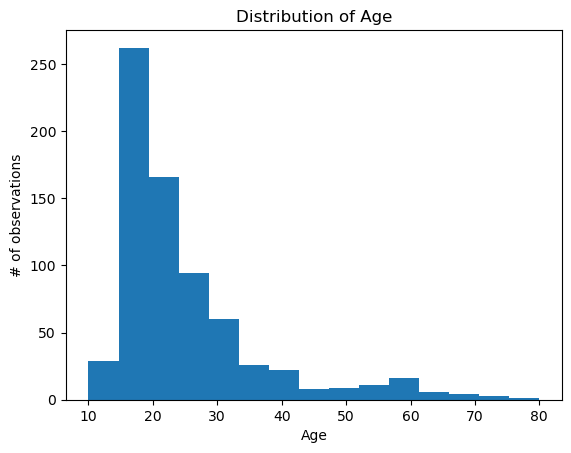

In [25]:
# Visualize distribution of Age

plt.hist(survey_df['Age'], bins=15)

plt.xlabel('Age')
plt.ylabel('# of observations')
plt.title('Distribution of Age')

plt.show()

Since the distribution is significantly right-skewed, we'll go ahead and create 5 equally sized bins in order to investigate the relationship with how frequently they listen to each genre.

In [26]:
# Bin Age column into 5 equally sized bins

bins, bin_edges = pd.qcut(survey_df['Age'], retbins=True, q=5)
labels = [f"{int(bin_edges[i])}-{int(bin_edges[i+1])}" for i in range(len(bin_edges)-1)]
survey_df['Age_Binned'] = pd.qcut(survey_df['Age'], labels=labels, q=5)

In [27]:
# Transform data so we can plot the data based on number of very frequent listeners per age group

frequency_cols = list(survey_df.columns[survey_df.columns.str.startswith('Fr')])

very_frequent_listeners = survey_df[(survey_df[frequency_cols] == 'Very frequently').any(axis=1)]
melted_df = very_frequent_listeners.melt(id_vars=['Age', 'Age_Binned'], value_vars=frequency_cols, var_name='Genre', value_name='Frequency')

# Filter for 
melted_df = melted_df[melted_df['Frequency'] == 'Very frequently']

# Prettify Genre column so it only lists the actual Genre
melted_df['Genre'] = melted_df['Genre'].apply(lambda x: str(re.findall(r'\[(.*?)\]', x)[0]))

melted_df

,Age,Age_Binned,Genre,Frequency
10,18,17-19,Classical,Very frequently
25,19,17-19,Classical,Very frequently
28,16,10-17,Classical,Very frequently
35,18,17-19,Classical,Very frequently
36,37,30-80,Classical,Very frequently
...,...,...,...,...
10774,35,30-80,Video game music,Very frequently
10778,17,10-17,Video game music,Very frequently
10782,17,10-17,Video game music,Very frequently
10783,22,19-23,Video game music,Very frequently


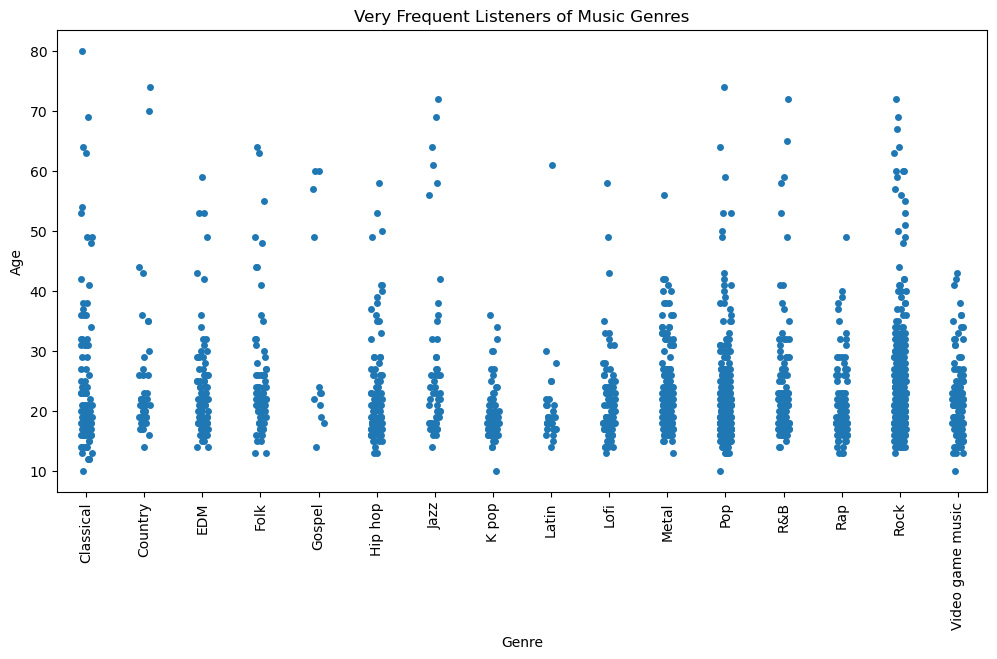

In [28]:
# Plot strip-plot of very frequent listeners of each genre and group by age groups

plt.figure(figsize=(12, 6))
sns.stripplot(x='Genre', y='Age', data=melted_df)

plt.xticks(rotation=90)
plt.title('Very Frequent Listeners of Music Genres')

plt.show()

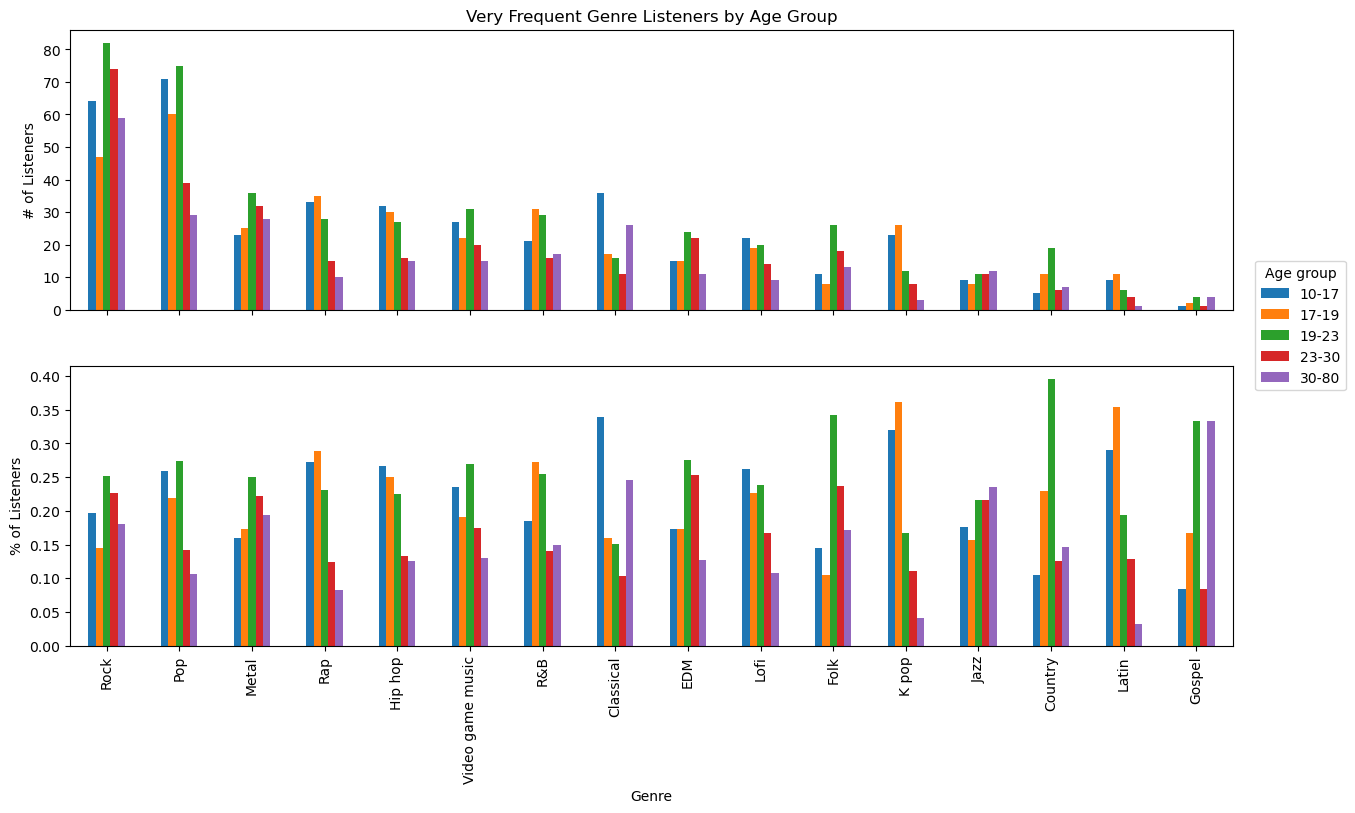

In [29]:
# Create contingency table and plot data

contingency_table = pd.crosstab(melted_df['Genre'], melted_df['Age_Binned'], margins=True).sort_values(by='All', ascending=False)
contingency_table = contingency_table.drop('All', axis='index').drop('All', axis=1)

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15, 8))
contingency_table.plot(kind='bar', ax=ax[0])

ax[0].set_title('Very Frequent Genre Listeners by Age Group')
ax[0].set_xlabel('Genre')
ax[0].set_ylabel('# of Listeners')
ax[0].legend_ = None
fig.legend(title='Age group', bbox_to_anchor=(0.98,0.6))

# Plot normalized data for comparison

normalized_table = pd.crosstab(melted_df['Genre'], melted_df['Age_Binned'], normalize=0).reindex(contingency_table.index)
normalized_table.plot(kind='bar', ax=ax[1])
ax[1].set_ylabel('% of Listeners')
ax[1].legend_ = None

plt.show()

These visualizations provide many interesting and unexpected insights. Plotting the data without normalizing reinforces the fact that our Age distribution is heavily right-skewed. This can be seen by the sparsity of points in the stripplot above the age of 30. Therefore, we created an additional plot which allows us to compare the overal totals with proportional data.

As expected, certain genres have a higher proportion of younger listeners than older. These include genres such as Pop, Rap, Video game music, and hip hop. Surprisingly enough, classical music also saw greater popularity among younger groups, particularly those in the 10-17 group, than people above the age of 30. Similarly, older individuals made up a large chunk of gospel music listeners than those from the ages of 10-19. 

## Insomnia, Anxiety, OCD, and Depression

Let's investigate the relationship between age and these mental conditions.

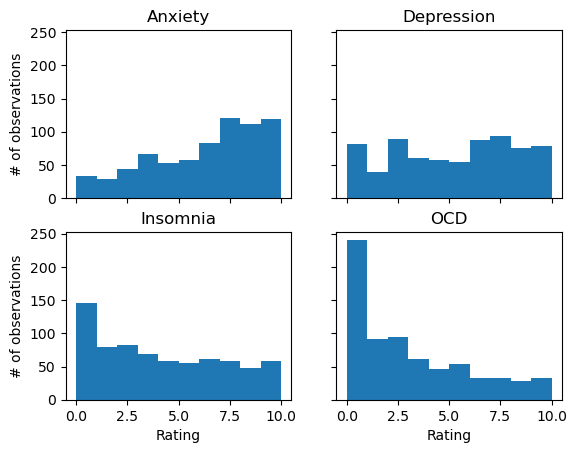

In [30]:
# Visualize distributions to determine whether lineplot should use median or mean

conditions = cols_to_bin

fig, ax = plt.subplots(2,2, sharex=True, sharey=True)

# Anxiety
ax[0][0].hist(survey_df[conditions[0]])
ax[0][0].set_title(conditions[0])

# Depression
ax[0][1].hist(survey_df[conditions[1]])
ax[0][1].set_title(conditions[1])

# Insomnia
ax[1][0].hist(survey_df[conditions[2]])
ax[1][0].set_title(conditions[2])

# OCD
ax[1][1].hist(survey_df[conditions[3]])
ax[1][1].set_title(conditions[3])

ax[1][0].set_xlabel('Rating')
ax[1][0].set_ylabel('# of observations')
ax[1][1].set_xlabel('Rating')
ax[0][0].set_ylabel('# of observations')

plt.show()

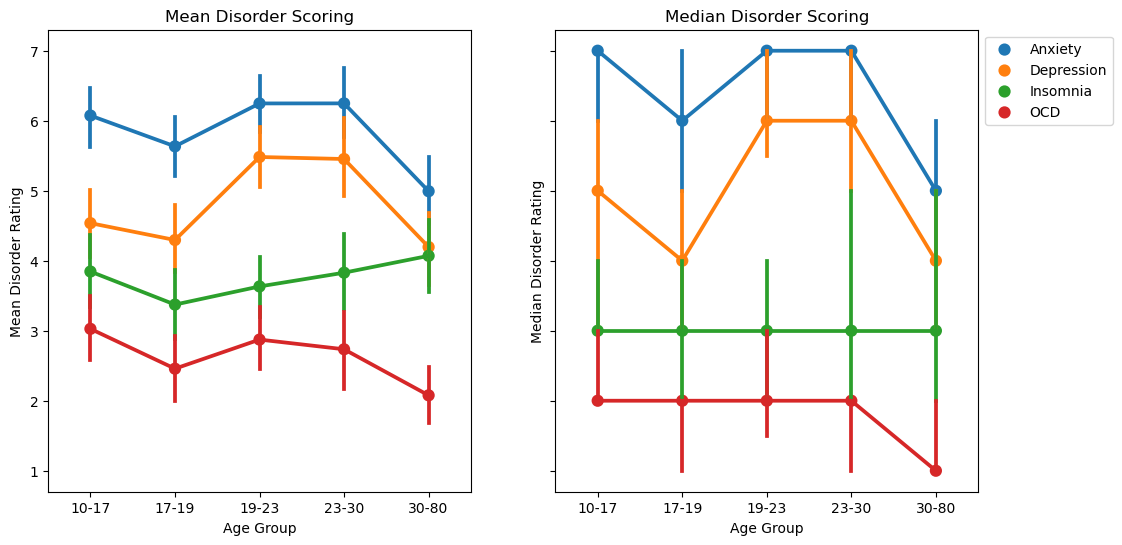

In [31]:
# Visualize relationship with line plots

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12,6))

for i, condition in enumerate(conditions):
    sns.pointplot(data=survey_df, x='Age_Binned', y=condition, ax=ax[0], color=sns.color_palette()[i], label=condition)
    sns.pointplot(data=survey_df, x='Age_Binned', y=condition, ax=ax[1], color=sns.color_palette()[i], label=condition, estimator='median')

ax[0].set_xlabel('Age Group')
ax[1].set_xlabel('Age Group')
ax[0].set_ylabel('Mean Disorder Rating')
ax[1].set_ylabel('Median Disorder Rating')
ax[0].set_title('Mean Disorder Scoring')
ax[1].set_title('Median Disorder Scoring')
plt.legend(bbox_to_anchor=(1,1))

plt.show()

These point plots reveal to us a number of key bits of information about our data. The degree to which patients are suffering from these conditions is not equal across the conditions themselves. Patients of this survey suffer more from Anxiety, for example, than OCD, which remains true regardless of age. Only participants aged 30 and above tend to converge at a mean rating of Anxiety, Depression, and Insomnia. 

## Hours per Day

Do patients of all ages spend the same amount of time listening to music? 

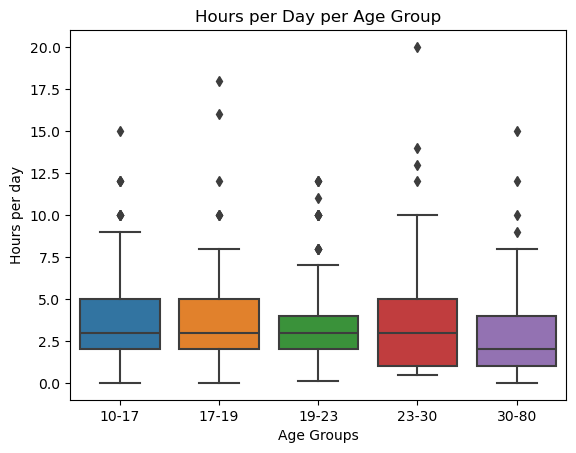

In [34]:
# Visualize relationship between age and hours per day

sns.boxplot(x='Age_Binned', y='Hours per day', data=survey_df[['Age_Binned', 'Hours per day']])

plt.xlabel('Age Groups')
plt.title('Hours per Day per Age Group')

plt.show()

It doesn't look like hours per day spent listening to music varies much by age group.

# Hours per Day

## Insomnia
Based on the previous analysis of Hours per Day spent listening to music grouped by Age Group, it looked like there were some significant outliers. The most logical explanation for this would be that those who listen to music so many hours in the day are also not sleeping much, hence they are probably insomniacs. We'll conduct an ANOVA test using `Insomnia_binned` to investigate the variance of mean `Hours per Day` across ranks.

**Null Hypothesis**: There is no difference in mean hours per day spent listening to music based on Insomnia level.

**Alternative Hypothesis**: Mean hours per day will be different based on someone's level of Insomnia.

In [40]:
# Conduct ANOVA test

# Insomnia_binned ranks
ranks = survey_df['Insomnia_binned'].unique()
hours_groups = [survey_df[survey_df['Insomnia_binned'] == rank]['Hours per day'] for rank in ranks]

# Perform one-way ANOVA
f_stat, p_value = f_oneway(*hours_groups)

print(f"F-statistic: {f_stat}, p-value: {p_value}")

F-statistic: 8.558948490294737, p-value: 0.0002122044146086839


With such a low p-value we can reject the null hypothesis. Let's use a Kendall's Tau-test to investigate the correlation between the two variables.

In [48]:
# Perform kendall-tau test

tau, p_value = kendalltau(survey_df['Hours per day'], survey_df['Insomnia_binned'])

print(f"Tau-value: {round(tau, 2)}, p_value: {p_value}")

Tau-value: 0.13, p_value: 3.355124202997094e-05


The two features are very weakly positively correlated, with tau = 0.13. 

# Favorite Genre

As evidenced by our initial report in our Data Wrangling notebook, there seemed to be some correlation between an individual's favorite genre and their most frequently listened to genres.

**Null hypothesis**: There is no relationship between someone's favorite genre and the genres they listen to most frequently.

**Alternative hypothesis**: An individual listens to their favorite genre very frequently.

In [67]:
# Define method which returns True if Fav genre's matching Frequency column has the value 'Very frequently'

def fav_frequent(row):
    favorite_genre = row['Fav genre']
    col_name = f"Frequency [{favorite_genre}]"
    return row[col_name] == 'Very frequently'

In [70]:
# Apply fav_frequent method

survey_df['Fav_frequent'] = survey_df.apply(fav_frequent, axis=1)

# Verify results

survey_df[['Fav genre', *frequency_cols, 'Fav_frequent']]

,Fav genre,Frequency [Classical],Frequency [Country],Frequency [EDM],Frequency [Folk],Frequency [Gospel],Frequency [Hip hop],Frequency [Jazz],Frequency [K pop],Frequency [Latin],Frequency [Lofi],Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Fav_frequent
0,Video game music,Never,Never,Very frequently,Never,Never,Rarely,Rarely,Very frequently,Never,Sometimes,Sometimes,Rarely,Never,Rarely,Rarely,Very frequently,True
1,Jazz,Sometimes,Never,Never,Rarely,Sometimes,Never,Very frequently,Sometimes,Very frequently,Sometimes,Never,Sometimes,Sometimes,Never,Never,Never,True
2,R&B,Never,Never,Rarely,Never,Rarely,Very frequently,Never,Very frequently,Sometimes,Sometimes,Never,Sometimes,Very frequently,Very frequently,Never,Rarely,True
3,Jazz,Rarely,Sometimes,Never,Never,Never,Sometimes,Very frequently,Very frequently,Rarely,Very frequently,Rarely,Very frequently,Very frequently,Very frequently,Very frequently,Never,True
4,Video game music,Sometimes,Never,Rarely,Sometimes,Rarely,Rarely,Sometimes,Never,Rarely,Rarely,Rarely,Rarely,Rarely,Never,Never,Sometimes,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,Rock,Very frequently,Rarely,Never,Sometimes,Never,Sometimes,Rarely,Never,Sometimes,Rarely,Rarely,Very frequently,Never,Rarely,Very frequently,Never,True
713,Pop,Rarely,Rarely,Never,Never,Never,Never,Rarely,Never,Never,Rarely,Never,Very frequently,Never,Never,Sometimes,Sometimes,True
714,Rap,Rarely,Sometimes,Sometimes,Rarely,Rarely,Very frequently,Rarely,Rarely,Rarely,Sometimes,Rarely,Sometimes,Sometimes,Sometimes,Rarely,Rarely,False
715,Classical,Very frequently,Never,Never,Never,Never,Never,Rarely,Never,Never,Never,Never,Never,Never,Never,Never,Sometimes,True


In [72]:
# Look at proportion of patients with matching fav genre and frequency

survey_df['Fav_frequent'].value_counts(normalize=True)

Fav_frequent
True     0.921897
False    0.078103
Name: proportion, dtype: float64

92% of patients very frequently listen to their favorite genres. This confirms our alternative hypothesis that these columns are correlated. High correlations such as this one could introduce multi-collinearity into our model, so we may need to drop either the Fav genre column or frequency columns.

# Exploratory

Some individuals regularly seek out new artists and genres. Someone who explores music in this way may have a more even distribution across their frequency columns. This will be done by converting the frequency columns into numerical values, calculating the variance across all of them, and comparing the variance between exploratory and non-exploratory patients.

**Null hypothesis**: Whether or not a person is exploratory does not affect the frequency with which they listen to various genres.

**Alternative hypothesis**: A person who is exploratory will have a more balanced distribution of frequencies across their frequency columns.

In [73]:
# Import ml preprocessing data for this since encoding already done there

encoded_df = pd.read_csv('./../data/processed/pre_processed_survey_results.csv')
encoded_df.head()

,Age,Hours per day,While working,Instrumentalist,Composer,Exploratory,Foreign languages,BPM,Frequency [Classical],Frequency [Country],...,fav_Jazz,fav_K pop,fav_Latin,fav_Lofi,fav_Metal,fav_Pop,fav_R&B,fav_Rap,fav_Rock,fav_Video game music
0,18,4.0,0,0,0,0,1,132.0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,61,2.5,1,0,1,1,1,84.0,2,0,...,1,0,0,0,0,0,0,0,0,0
2,18,4.0,1,0,0,1,0,107.0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,18,5.0,1,1,1,1,1,86.0,1,2,...,1,0,0,0,0,0,0,0,0,0
4,18,3.0,1,1,0,1,1,66.0,2,0,...,0,0,0,0,0,0,0,0,0,1


In [74]:
# Create new column called frequency_var which stores the variance across Frequency columns

encoded_df['frequency_var'] = encoded_df[frequency_cols].var(axis=1)
encoded_df.head()

,Age,Hours per day,While working,Instrumentalist,Composer,Exploratory,Foreign languages,BPM,Frequency [Classical],Frequency [Country],...,fav_K pop,fav_Latin,fav_Lofi,fav_Metal,fav_Pop,fav_R&B,fav_Rap,fav_Rock,fav_Video game music,frequency_var
0,18,4.0,0,0,0,0,1,132.0,0,0,...,0,0,0,0,0,0,0,0,1,1.316667
1,61,2.5,1,0,1,1,1,84.0,2,0,...,0,0,0,0,0,0,0,0,0,1.362500
2,18,4.0,1,0,0,1,0,107.0,0,0,...,0,0,0,0,0,1,0,0,0,1.562500
3,18,5.0,1,1,1,1,1,86.0,1,2,...,0,0,0,0,0,0,0,0,0,1.666667
4,18,3.0,1,1,0,1,1,66.0,2,0,...,0,0,0,0,0,0,0,0,1,0.533333


In [80]:
# Compare mean variance for both groups

encoded_df.groupby('Exploratory')['frequency_var'].mean()

Exploratory
0    1.020000
1    1.092184
Name: frequency_var, dtype: float64

Since these numbers are so close, we can assume they are not different. We can test this assumption using levene's test.

**Null hypothesis**: There is equal variance in genre frequency between Exploratory and non-Exploratory individuals.

**Alternative hypothesis**: Variance in genre frequency differs between exploratory and non-exploratory individuals.

In [102]:
# Perform levene's test

exploratory_group = encoded_df[encoded_df['Exploratory'] == 1][frequency_cols].to_numpy().flatten()
non_exploratory_group = encoded_df[encoded_df['Exploratory'] == 0][frequency_cols].to_numpy().flatten()

stat, p_value = levene(exploratory_group, non_exploratory_group)

print(f"Levene's statistic: {stat}, p_value: {p_value}")

Levene's statistic: 5.303743582065046, p_value: 0.02129737409029589


A p_value of 0.02 allows us to reject the null hypothesis. This means that there is a difference in variance between the two groups, with there being more mean variance among exploratory individuals.

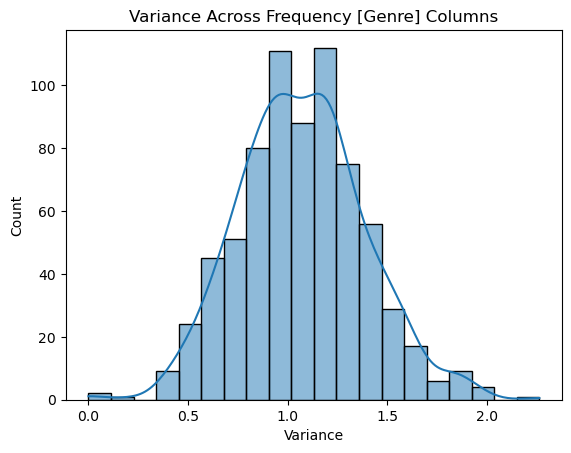

In [87]:
# Visualize distribution of variance

sns.histplot(encoded_df['frequency_var'], bins=20, kde=True)

plt.title('Variance Across Frequency [Genre] Columns')
plt.xlabel('Variance')

plt.show()

# Model Preprocessing

Although much of the preprocessing necessary was done in the preprocessing notebook, some, such as converting certain columns to type category, will be done here. This is in preparation for using prediction models.

In [25]:
# Load preprocessed data

ml_survey_df = pd.read_csv('../data/processed/pre_processed_survey_results.csv')
ml_survey_df.head()

,Age,Hours per day,While working,Instrumentalist,Composer,Exploratory,Foreign languages,BPM,Frequency [Classical],Frequency [Country],...,fav_Jazz,fav_K pop,fav_Latin,fav_Lofi,fav_Metal,fav_Pop,fav_R&B,fav_Rap,fav_Rock,fav_Video game music
0,18,4.0,0,0,0,0,1,132.0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,61,2.5,1,0,1,1,1,84.0,2,0,...,1,0,0,0,0,0,0,0,0,0
2,18,4.0,1,0,0,1,0,107.0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,18,5.0,1,1,1,1,1,86.0,1,2,...,1,0,0,0,0,0,0,0,0,0
4,18,3.0,1,1,0,1,1,66.0,2,0,...,0,0,0,0,0,0,0,0,0,1


## Datatype Conversions

In [26]:
# Convert While working, Instrumentalist, Composer, Fav genre, Exploratory, Anxiety, Depression, Insomnia, OCD, Music effects, and Foreign languages to type category.

columns_to_convert = ['While working', 'Instrumentalist', 'Composer', 'Exploratory', 'Foreign languages', 'Anxiety', 'Depression', 'Insomnia', 'OCD']

ml_survey_df[columns_to_convert] = ml_survey_df[columns_to_convert].astype('category')

In [27]:
# Convert Frequency columns into category

frequency_columns = list(ml_survey_df.columns[ml_survey_df.columns.str.startswith('Fr')])
ml_survey_df[frequency_columns] = ml_survey_df[frequency_columns].astype('category')

ml_survey_df[frequency_columns]

,Frequency [Classical],Frequency [Country],Frequency [EDM],Frequency [Folk],Frequency [Gospel],Frequency [Hip hop],Frequency [Jazz],Frequency [K pop],Frequency [Latin],Frequency [Lofi],Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music]
0,0,0,3,0,0,1,1,3,0,2,2,1,0,1,1,3
1,2,0,0,1,2,0,3,2,3,2,0,2,2,0,0,0
2,0,0,1,0,1,3,0,3,2,2,0,2,3,3,0,1
3,1,2,0,0,0,2,3,3,1,3,1,3,3,3,3,0
4,2,0,1,2,1,1,2,0,1,1,1,1,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,3,1,0,2,0,2,1,0,2,1,1,3,0,1,3,0
716,1,1,0,0,0,0,1,0,0,1,0,3,0,0,2,2
717,1,2,2,1,1,3,1,1,1,2,1,2,2,2,1,1
718,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2


In [28]:
# Confirm all conversions

ml_survey_df.dtypes

Age                                int64
Hours per day                    float64
While working                   category
Instrumentalist                 category
Composer                        category
Exploratory                     category
Foreign languages               category
BPM                              float64
Frequency [Classical]           category
Frequency [Country]             category
Frequency [EDM]                 category
Frequency [Folk]                category
Frequency [Gospel]              category
Frequency [Hip hop]             category
Frequency [Jazz]                category
Frequency [K pop]               category
Frequency [Latin]               category
Frequency [Lofi]                category
Frequency [Metal]               category
Frequency [Pop]                 category
Frequency [R&B]                 category
Frequency [Rap]                 category
Frequency [Rock]                category
Frequency [Video game music]    category
Anxiety         

# Logistic Regression

In [29]:
# Scale Age, Hours per day, and BPM

cols_to_scale = ['Age', 'Hours per day', 'BPM']

# Initialize Scaler 

scaler = StandardScaler()

# Fit scaler

ml_survey_df[cols_to_scale] = scaler.fit_transform(ml_survey_df[cols_to_scale])
ml_survey_df

,Age,Hours per day,While working,Instrumentalist,Composer,Exploratory,Foreign languages,BPM,Frequency [Classical],Frequency [Country],...,fav_Jazz,fav_K pop,fav_Latin,fav_Lofi,fav_Metal,fav_Pop,fav_R&B,fav_Rap,fav_Rock,fav_Video game music
0,-0.599385,0.131555,0,0,0,0,1,0.320697,0,0,...,0,0,0,0,0,0,0,0,0,1
1,3.070901,-0.361006,1,0,1,1,1,-1.239520,2,0,...,1,0,0,0,0,0,0,0,0,0
2,-0.599385,0.131555,1,0,0,1,0,-0.491916,0,0,...,0,0,0,0,0,0,1,0,0,0
3,-0.599385,0.459928,1,1,1,1,1,-1.174511,1,2,...,1,0,0,0,0,0,0,0,0,0
4,-0.599385,-0.196819,1,1,0,1,1,-1.824601,2,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,-0.684741,-0.525192,1,1,0,1,1,-0.069358,3,1,...,0,0,0,0,0,0,0,0,1,0
716,-0.599385,-0.853566,1,1,0,1,1,1.230823,1,1,...,0,0,0,0,0,1,0,0,0,0
717,-0.514030,0.788302,1,0,1,1,0,-0.069358,1,2,...,0,0,0,0,0,0,0,1,0,0
718,-0.514030,0.459928,1,1,0,0,0,1.555868,3,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
ml_survey_df.columns

Index(['Age', 'Hours per day', 'While working', 'Instrumentalist', 'Composer',
       'Exploratory', 'Foreign languages', 'BPM', 'Frequency [Classical]',
       'Frequency [Country]', 'Frequency [EDM]', 'Frequency [Folk]',
       'Frequency [Gospel]', 'Frequency [Hip hop]', 'Frequency [Jazz]',
       'Frequency [K pop]', 'Frequency [Latin]', 'Frequency [Lofi]',
       'Frequency [Metal]', 'Frequency [Pop]', 'Frequency [R&B]',
       'Frequency [Rap]', 'Frequency [Rock]', 'Frequency [Video game music]',
       'Anxiety', 'Depression', 'Insomnia', 'OCD', 'Improve', 'No effect',
       'Worsen', 'fav_Country', 'fav_EDM', 'fav_Folk', 'fav_Gospel',
       'fav_Hip hop', 'fav_Jazz', 'fav_K pop', 'fav_Latin', 'fav_Lofi',
       'fav_Metal', 'fav_Pop', 'fav_R&B', 'fav_Rap', 'fav_Rock',
       'fav_Video game music'],
      dtype='object')

## Modelling `Improve`

We will develop a logistic regression test to model Improve, which contains a binary value for whether or not the patient improved after music therapy treatment. This column, along with No effect and Worsen will be left out of the explanatory variables since including both Worsen and No effect would introduce significant multi-collinearity to the model.

In [32]:
# Separate data in dependent and explanatory variables

X = ml_survey_df.drop(['Improve', 'No effect', 'Worsen'], axis=1)
y = ml_survey_df['Improve']

# Split data in training and testing data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=random_state)

# Set up cross-validation and logistic regression

kf = KFold(shuffle=True, random_state=random_state)
lr = LogisticRegression(max_iter=1000)

# Run model and print summarized results

cv_results = cross_val_score(lr, X_train, y_train, cv=kf)
print(f"Standard deviation of accuracy scores: {round(np.std(cv_results), 2)}")
print(f"Mean accuracy score: {round(np.mean(cv_results), 2)}")

Standard deviation of accuracy scores: 0.05
Mean accuracy score: 0.72


The average accuracy score of our model across 5 folds is 0.72 with a standard deviation of 0.05. There is low variance across tests, implying that the model's performance is fairly consistent across different splits. In order to quantify whether or not a mean accuracy score of 0.72 will suffice, we will calculate a no-information rate for Improve. This is the accuracy rate that can be achieved without a model, where random samples will be taken from the data.

In [33]:
# Calculate no-information rate for Improve

print(f"No-Information rate for True predictions: {round(ml_survey_df['Improve'].value_counts(normalize=True)[1], 2)}")

No-Information rate for True predictions: 0.74


The average performance of our model is worse than if we were to select randomly from the sample data. We'll try to improve our model through hyperparameter tuning.

In [38]:
# Set up hyperparameter tuning with a grid search

param_grid = {
    'penalty' : ['elasticnet', 'l2', 'l1'],
    'C' : np.linspace(0, 4),
    'solver' : ['lbfgs', 'liblinear', 'saga']
}

lr = LogisticRegression(max_iter=3000)
model_cv = GridSearchCV(lr, param_grid, cv=kf)
model_cv.fit(X_train, y_train)

# Print results

print(f"Mean accuracy score: {round(model_cv.best_score_, 2)}")
print(f"Best parameters: {model_cv.best_params_}")

Mean accuracy score: 0.75
Best parameters: {'C': 0.24489795918367346, 'penalty': 'l1', 'solver': 'liblinear'}


/home/arsen/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.73215842 0.73413861 0.73215842        nan 0.7460198  0.7440198
        nan        nan        nan 0.73213861 0.73213861 0.73213861
        nan 0.748      0.7440396         nan        nan        nan
 0.72223762 0.72819802 0.72619802        nan 0.7519802  0.7460396
        nan        nan        nan 0.72221782 0.72619802 0.72419802
        nan 0.74007921 0.73609901        nan        nan        nan
 0.72223762 0.72619802 0.72223762        nan 0.73413861 0.72817822
        nan        nan        nan 0.72025743 0.72025743 0.72025743
        nan 0.73413861 0.72817822        nan        nan        nan
 0.72025743 0.72223762 0.72025743        nan 0.73411881 0.73015842
        nan        nan        nan 0.71827723 0.

By tuning the chosen hyperparameters, we achieved a mean accuracy score of 0.75, which is just slightly better than our no-information rate. We'll see how this model performs on our test data.

In [35]:
# Fit model with best parameters to hidden test data

predictions = model_cv.predict(X_test)

# Visualize performance with classification report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.44      0.07      0.12        55
           1       0.75      0.97      0.85       161

    accuracy                           0.74       216
   macro avg       0.60      0.52      0.49       216
weighted avg       0.67      0.74      0.66       216



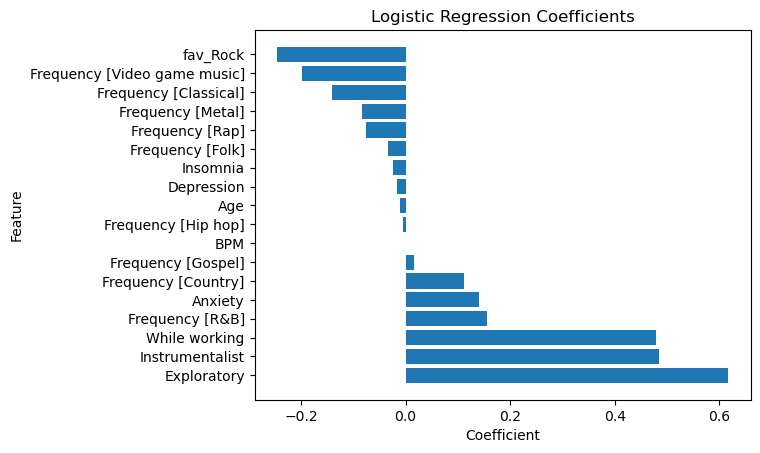

In [39]:
# Create dataframe of coefficients and plots visualization

coefficient_df = pd.DataFrame({'Feature':X.columns, 'Coefficient':model_cv.best_estimator_.coef_[0]}).sort_values(by='Coefficient', ascending=False).reset_index(drop=True)
relevant_coef = coefficient_df[coefficient_df['Coefficient'] != 0]

plt.barh(relevant_coef['Feature'], relevant_coef['Coefficient'])

plt.title('Logistic Regression Coefficients')
plt.xlabel('Coefficient')
plt.ylabel('Feature')

plt.show()